# Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [248]:
import json
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.svm import SVC
from xgboost import plot_importance
from xgboost import XGBClassifier

In [249]:
# Load json file into pandas dataframe
login_df = pd.read_json('logins.json')
login_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [250]:
#Check dataframe
login_df.describe(datetime_is_numeric=True)

,login_time
count,93142
mean,1970-02-26 19:09:39.779648278
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


In [251]:
login_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [252]:
#set index to login_time
login_df = login_df.set_index(['login_time'])
login_df['count'] = np.ones(len(df_logins))
login_df.head()

,count
login_time,
1970-01-01 20:13:18,1.0
1970-01-01 20:16:10,1.0
1970-01-01 20:16:37,1.0
1970-01-01 20:16:36,1.0
1970-01-01 20:26:21,1.0


In [253]:
#set login_time to 15 mins interval 
login_df['count'] = 1
login_df_15min = login_df.resample('15 min').count()
login_df_15min.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [254]:
login_df_15min['time'] = login_df_15min.reset_index()['login_time'].dt.time.tolist()
login_df_15min['day_of_week'] = login_df_15min.reset_index()['login_time'].dt.dayofweek.tolist()
login_df_15min['month'] = login_df_15min.reset_index()['login_time'].dt.month.tolist()
login_df_15min.reset_index(drop=True, inplace=True)
login_df_15min.head()

,count,time,day_of_week,month
0,2,20:00:00,3,1
1,6,20:15:00,3,1
2,9,20:30:00,3,1
3,7,20:45:00,3,1
4,1,21:00:00,3,1


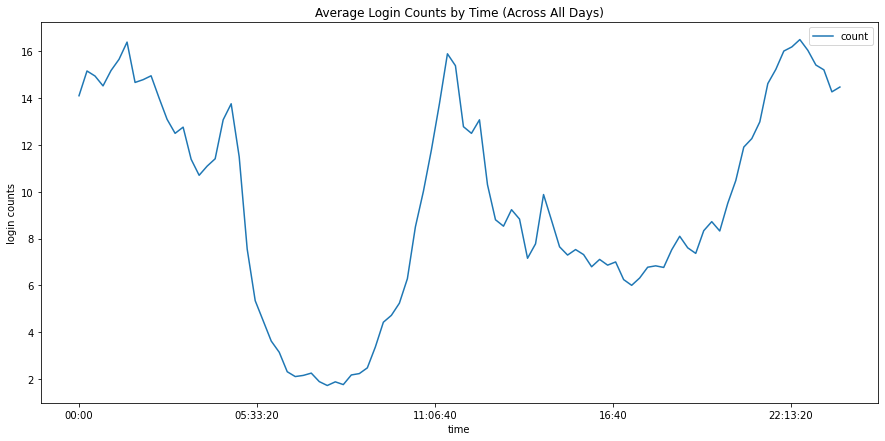

In [255]:
fig, ax = plt.subplots(figsize=(15,7))
login_df_15min.groupby(['time']).mean().reset_index().plot(x='time', y='count', ax=ax)
ax.set_ylabel('login counts')
ax.set_title('Average Login Counts by Time (Across All Days)')
plt.show()

Looks like there are two peaks, during early morning and late night. Now lets explore day to day throughout the week. 

In [256]:
# resample by day to count total daily average number of logins
logins_day = login_df.resample('D').sum()
logins_day['day_of_week'] = login_df.resample('D').sum().reset_index()['login_time'].dt.dayofweek.tolist()
logins_day.head()

,count,day_of_week
login_time,,
1970-01-01,112,3
1970-01-02,681,4
1970-01-03,793,5
1970-01-04,788,6
1970-01-05,459,0


In [257]:
def plot_days(day):
    '''make a plot of the number of logins vs day, where day is a number 0-6 starting with monday and annotate 
        the plot with the total daily average for that day'''
    fig, ax = plt.subplots(figsize=(16,8))
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df = login_df_15min.groupby(['day_of_week', 'time']).sum().loc[day].reset_index()
    df.plot(x='time', y='count', legend=False, ax=ax)
    
    daily_avg = int(logins_day.groupby(['day_of_week']).sum().loc[i]
                    / logins_day.day_of_week.value_counts()[i])
    y=login_df.min()
    ax.annotate('{} average total logins: {}'.format(days[i], daily_avg), xy=(0, 50), xytext=(60000, y), size=14)
    ax.set_title(days[day])
    ax.set_ylabel('login_count')

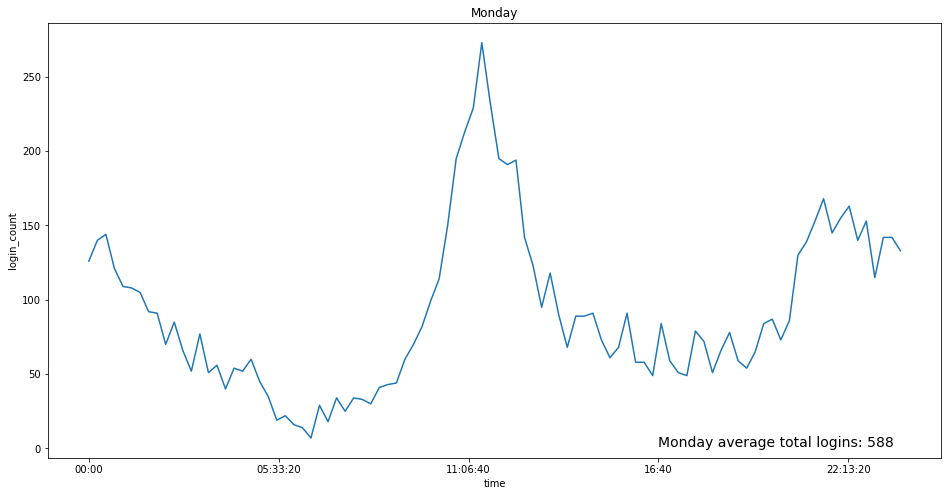

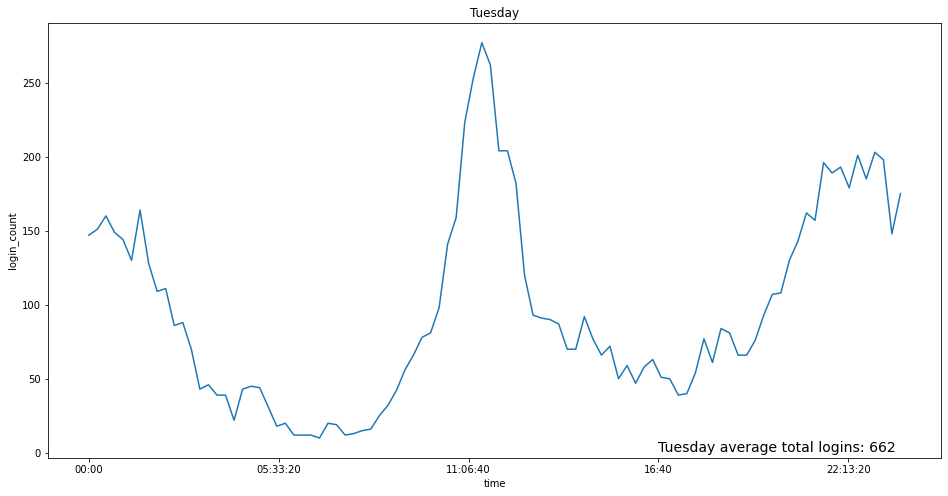

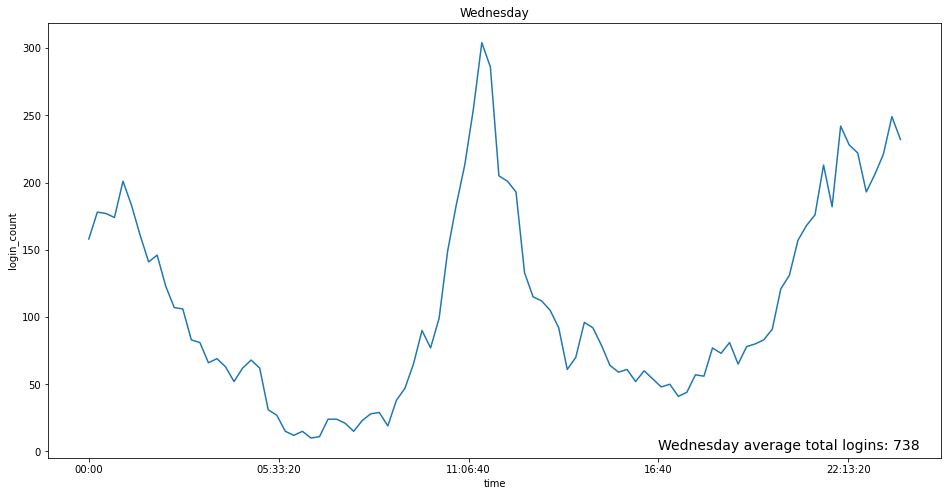

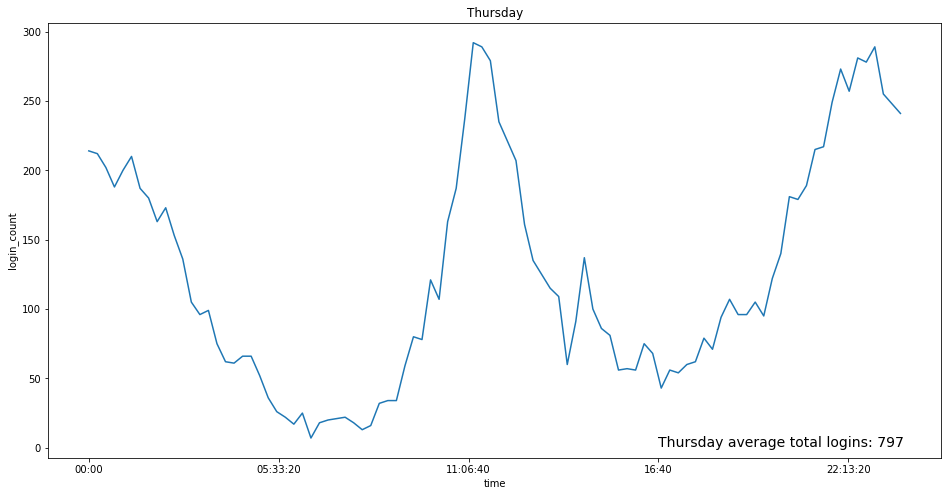

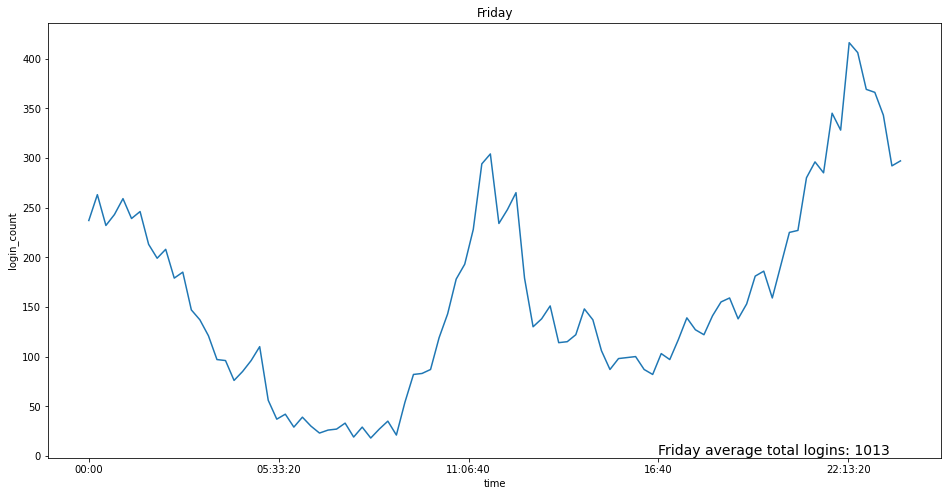

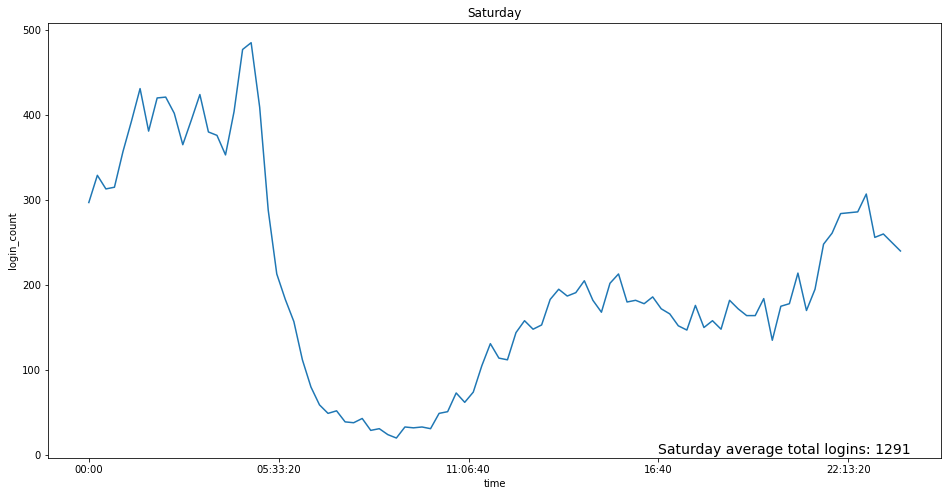

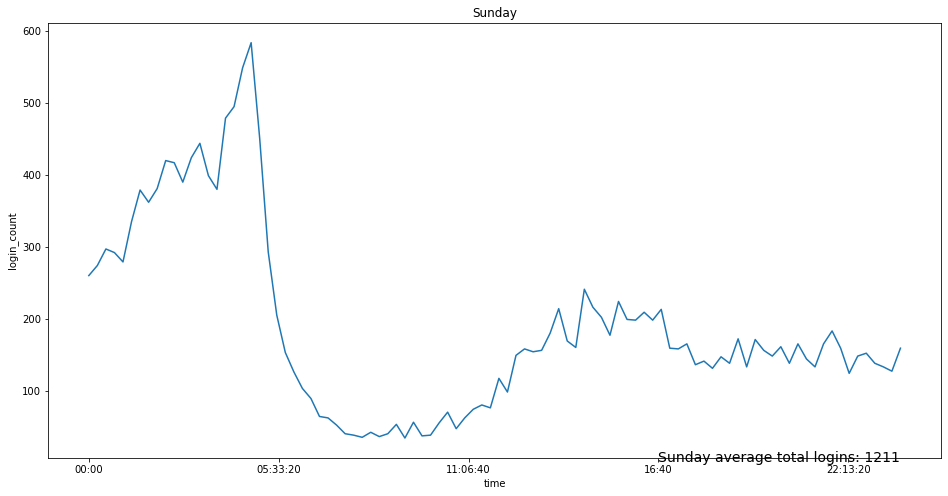

In [258]:
for i in range(7):
    plot_days(i)

1. The amount of logins increase during Monday through Friday around early morning and late at night.
2. The logins decrease significantly on the Weekends. 

# Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a) how you will implement the experiment

b) what statistical test(s) you will conduct to verify the significance of the observation

c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

# Solution

1. Increase driver and rider acceptance rates
2. Increase driver and rider sign ups
3. Reduce driver and rider wait times
4. Increase profit

We can do a A/B study where we randomly select half the drivers to participate in the experiment while leaving the other half alone. At the end of the study given a set time, we can compare the profitability. Once we have the results we can use a t-test to test for significance (p=0.05) between the two groups. 

# Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [259]:
import json
from pandas import json_normalize

json_users = json.load((open('ultimate_data_challenge.json')))
df_users = json_normalize(json_users)
print(df_users.info())
df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


Data looks clean

In [260]:
df_users['retained'] = [date > '2014-06-01' for date in df_users.last_trip_date]

In [261]:
frac_retained = df_users.retained.value_counts()[1]/df_users.retained.value_counts()[0]
print('Fraction of observed users retained: {:.2f}'.format(frac_retained))

Fraction of observed users retained: 0.58


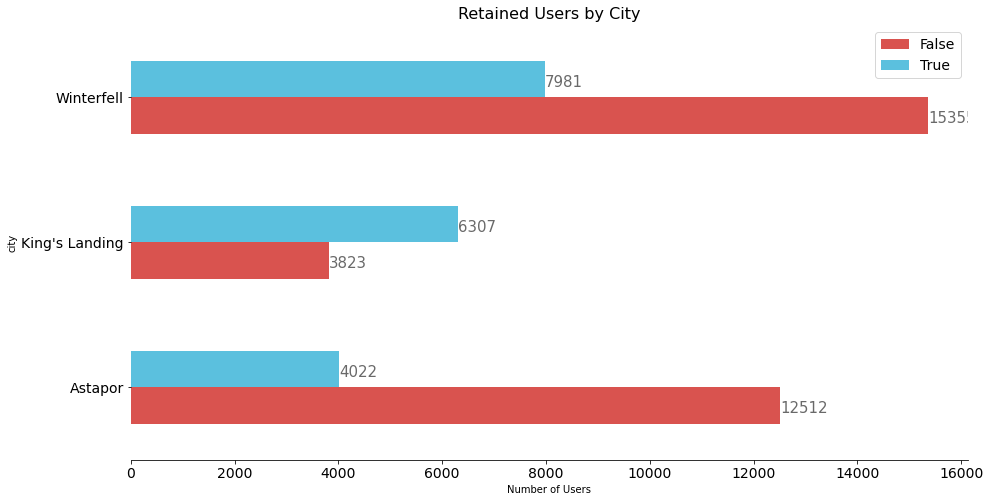

In [262]:
ax = df_users.groupby(['retained'])['city'].value_counts().unstack(0).plot.barh(figsize=(15,8),
                                                                                   width=0.5,
                                                                                   color=['#d9534f', '#5bc0de'],
                                                                                   fontsize=14)

plt.legend(fontsize=14)
plt.title("Retained Users by City",
         fontsize=16)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_width(), i.get_y()+.075, \
            str(int(i.get_width())), fontsize=15,
                color='dimgrey', clip_on=True)

ax.set_xlabel('Number of Users')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

King's Landing is more likely to be retained than the other two cities

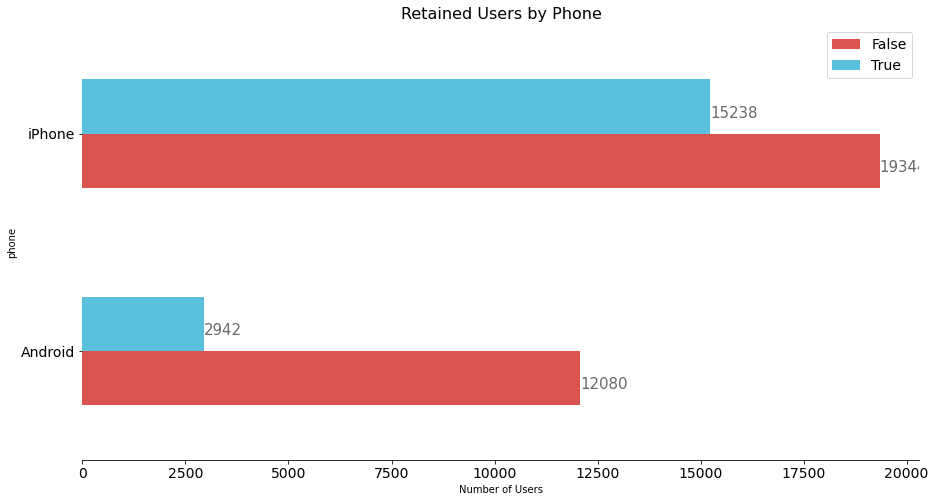

In [263]:
ax = df_users.groupby(['retained'])['phone'].value_counts().unstack(0).plot.barh(figsize=(15,8),
                                                                                   width=0.5,
                                                                                   color=['#d9534f', '#5bc0de'],
                                                                                   fontsize=14)

plt.legend(fontsize=14)
plt.title("Retained Users by Phone",
         fontsize=16)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_width(), i.get_y()+.075, \
            str(int(i.get_width())), fontsize=15,
                color='dimgrey', clip_on=True)

ax.set_xlabel('Number of Users')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

iPhone users are more likely to be retained than Android users

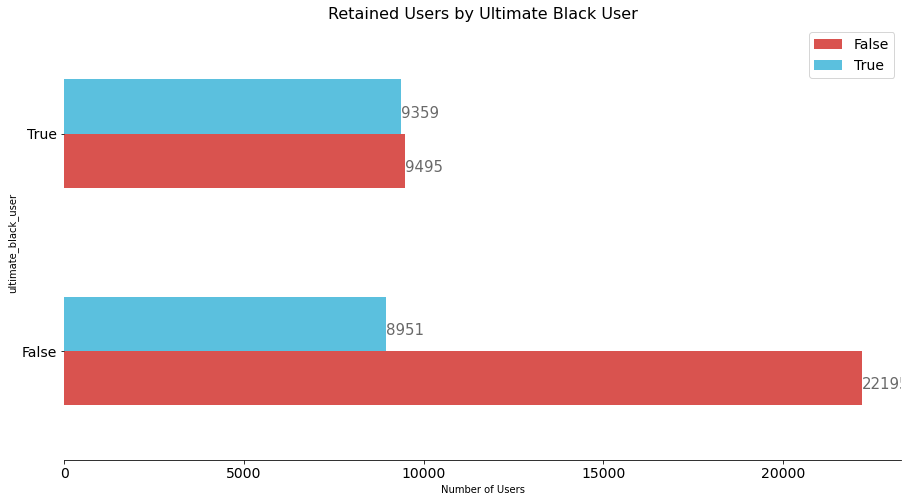

In [264]:
ax = df_users.groupby(['retained'])['ultimate_black_user'].value_counts().unstack(0).plot.barh(figsize=(15,8),
                                                                                   width=0.5,
                                                                                   color=['#d9534f', '#5bc0de'],
                                                                                   fontsize=14)

plt.legend(fontsize=14)
plt.title("Retained Users by Ultimate Black User",
         fontsize=16)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_width(), i.get_y()+.075, \
            str(int(i.get_width())), fontsize=15,
                color='dimgrey', clip_on=True)

ax.set_xlabel('Number of Users')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

Ultimate black users more likey to retained than non ultimate black users

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

In [265]:
sixth_month_active = [(pd.to_datetime(df_users.last_trip_date.iloc[i]) \
                       - pd.to_datetime(df_users.signup_date.iloc[i])).days > 152 for i in range(len(df_users))]

In [266]:
df_users['sixth_month_active'] = sixth_month_active
df_users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,sixth_month_active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True,False
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False,False


In [267]:
df_users['sixth_month_active'].value_counts()

False    38806
True     11194
Name: sixth_month_active, dtype: int64

In [268]:
df_users_train, df_users_test = train_test_split(df_users, test_size=0.2, random_state=4)

In [269]:
# binarizing 'city' and 'phone' columns
df_users_train = pd.concat([df_users_train, pd.get_dummies(df_users_train['city']), 
                            pd.get_dummies(df_users_train['phone'])], axis=1)

# converting 'ultimate_black_user' and 'sixth_month_active' columns from bool to int
df_users_train['ultimate_black_user'] = df_users_train['ultimate_black_user'].astype('uint8')
df_users_train['sixth_month_active'] = df_users_train['sixth_month_active'].astype('uint8')

df_users_train.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,sixth_month_active,Astapor,King's Landing,Winterfell,Android,iPhone
16880,King's Landing,2,2014-01-30,5.0,1.00,2014-02-02,iPhone,0.0,0,50.0,7.59,5.0,False,0,0,1,0,0,1
18337,Astapor,2,2014-01-10,4.8,1.02,2014-06-29,iPhone,8.3,0,75.0,8.09,5.0,True,1,1,0,0,0,1
11170,Astapor,0,2014-01-13,4.0,1.00,2014-03-02,iPhone,0.0,0,0.0,2.17,3.0,False,0,1,0,0,0,1
17714,Winterfell,2,2014-01-29,5.0,1.00,2014-03-16,iPhone,0.0,0,66.7,1.99,4.7,False,0,0,0,1,0,1
28539,Winterfell,0,2014-01-05,NaN,1.00,2014-02-09,iPhone,0.0,0,0.0,10.35,2.0,False,0,0,0,1,0,1


In [270]:
# imputing missing values with the mean using sklearn's SimpleImputer
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# selecting all features to compute importance
features = df_users_train.iloc[:, [0,1,2,3,8,9,10,11,14,15,16,17,18]].columns
X_train = df_users_train[features]

# setting target variable
y_train = df_users_train.loc[:,'sixth_month_active']


# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest.fit(imp_mode.fit_transform(X_train), y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = [X_train.columns[index] for index in indices] #reordering features by importance
sorted_importances = [importances[index] for index in indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), features)
plt.xticks(rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=12)
plt.show()

ValueError: could not convert string to float: "King's Landing"

In [271]:
# selecting features to train models
X_train = df_users_train[features]

# setting target variable
y_train = df_users_train.loc[:,'sixth_month_active']


# repeating pre-processing for the test data

# one-hot encoding of 'fittype' feature
df_users_test = pd.concat([df_users_test, pd.get_dummies(df_users_test['city']), 
                           pd.get_dummies(df_users_test['phone'])], axis=1)

# converting 'ultimate_black_user' and 'sixth_month_active' columns from bool to int
df_users_test['ultimate_black_user'] = df_users_test['ultimate_black_user'].astype('uint8')
df_users_test['sixth_month_active'] = df_users_test['sixth_month_active'].astype('uint8')


X_test = df_users_test[features]
y_test = df_users_test.loc[:,'sixth_month_active']

In [272]:
def return_time(seconds):
    '''converts seconds to hours, minutes, and seconds'''
    d = str(dt.timedelta(seconds=round(seconds)))
    hours = d[:len(d)-6]
    minutes = d[-5:-3]
    seconds_left = d[-2:]
    periods = [('hours', hours), ('minutes', minutes), ('seconds', seconds_left)]
    time_string = ' '.join('{} {}'.format(value, name)
                        for name, value in periods
                        if int(value) != 0)
    return time_string

In [273]:
# create LogisticRegression model and pipeline
logreg = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=7)
lr_steps = [('imputation', imp_mode), ('scaler', StandardScaler()), ('LR', logreg)]
lr_pipeline = Pipeline(lr_steps)

# paramater space to tune
c_space = np.logspace(-5,8,15)
lr_param_grid = {'LR__C': c_space}

In [274]:
start = time.time()
# apply 5 fold cross validation with RandomizedSearchCV to find best hyper-paramters and fit model
logreg_cv = RandomizedSearchCV(lr_pipeline, lr_param_grid, scoring='balanced_accuracy', cv=5, random_state=10)
logreg_cv.fit(X_train, y_train)

# print results
print("5 fold cross validation results")
print("---------------------------------------------------------------------")
print("Logistic Regression took {} to fit.".format(return_time(time.time() - start)))
print("Mean balanced accuracy: {:.3f}".format(np.mean(logreg_cv.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(logreg_cv.cv_results_['std_test_score'])))

/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit

/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit

/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit

/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit

/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit

/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit

/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit

/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit

/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit

/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit

/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit

/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit

/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/philip/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit

ValueError: could not convert string to float: "King's Landing"